In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm

# 1. Przygotowanie danych z czujnika

In [2]:
recording_list_files = os.listdir('sensor')
print(recording_list_files)

['2022-12-03T184634_data.txt', '2022-12-03T184735_data.txt', '2022-12-03T184836_data.txt', '2022-12-03T184937_data.txt', '2022-12-03T185037_data.txt', '2022-12-03T185138_data.txt', '2022-12-03T185239_data.txt', '2022-12-03T185340_data.txt', '2022-12-03T185440_data.txt', '2022-12-03T185541_data.txt', '2022-12-03T185642_data.txt', '2022-12-03T185742_data.txt', '2022-12-03T185843_data.txt', '2022-12-03T185944_data.txt', '2022-12-03T190045_data.txt', '2022-12-03T190145_data.txt', '2022-12-03T190207_data.txt', '2022-12-03T190308_data.txt', '2022-12-03T190409_data.txt', '2022-12-03T190509_data.txt', '2022-12-03T190610_data.txt', '2022-12-03T190711_data.txt', '2022-12-03T190812_data.txt', '2022-12-03T190912_data.txt', '2022-12-03T191013_data.txt', '2022-12-03T191114_data.txt', '2022-12-03T191215_data.txt', '2022-12-03T191316_data.txt', '2022-12-03T191445_data.txt', '2022-12-03T191545_data.txt', '2022-12-03T191646_data.txt', '2022-12-03T191747_data.txt', '2022-12-03T191848_data.txt', '2022-12-

In [3]:
recordings = []
for filename in recording_list_files:
    file_dir = os.path.join('sensor', filename)
    file = open(file_dir, 'r').read()
    file_split = file.split('\n')[:-1]
    for x in file_split:
        e = x.split(';')
        e[0] = float(e[0])
        e[1] = int(e[1])
        e[2] = int(e[2])
        # e[0] = datetime.datetime.fromtimestamp(e[0])
        recordings.append(e)

print(recordings[0:20])

[[1670089595.191516, 3864, 1], [1670089595.215675, 3889, 1], [1670089595.24067, 3914, 1], [1670089595.26567, 3939, 2], [1670089595.290674, 3964, 2], [1670089595.315688, 3989, 2], [1670089595.340675, 4014, 2], [1670089595.365674, 4039, 1], [1670089595.390674, 4064, 1], [1670089595.415674, 4089, 1], [1670089595.440679, 4114, 1], [1670089595.465675, 4139, 1], [1670089595.490674, 4164, 1], [1670089595.515674, 4189, 1], [1670089595.540679, 4214, 1], [1670089595.565675, 4239, 1], [1670089595.590674, 4264, 1], [1670089595.615674, 4289, 1], [1670089595.640674, 4314, 1], [1670089595.665679, 4339, 1]]


## 1.2 Odstępy czasowe pomiędzy próbkami

Dzięki temu możliwe jest odzielenie ich do 3 poszczególnych nagrań video

Id of new recordings: 35924
Id of new recordings: 62235


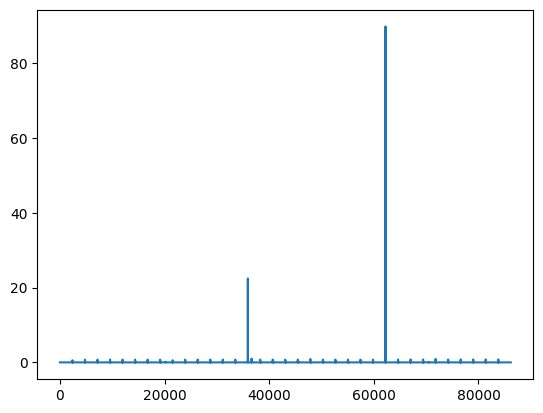

In [4]:
rs = []
recordings_new_id = []
for a in range(len(recordings) - 1):
    x = recordings[a]
    y = recordings[a + 1]
    r = y[0] - x[0]
    rs.append(r)

    if r > 10:
        print(f'Id of new recordings: {a}')
        recordings_new_id.append(a)

plt.plot(rs)
plt.show()

## 1.3 Odstępy pomiędzy podzielonymi próbkami
Podczas tworzenia nowego pliku można zauważyć duży odstęp

[35924, 62235]


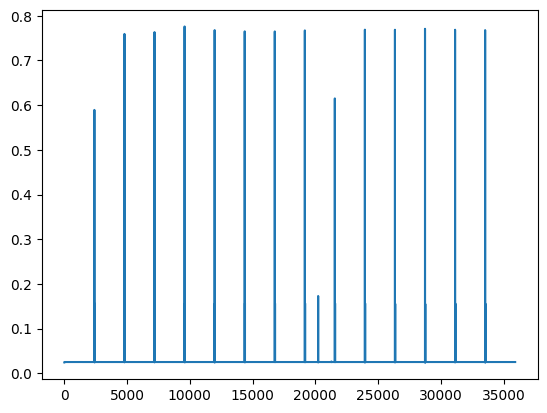

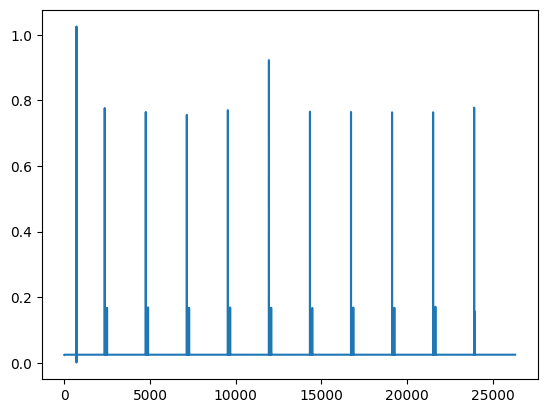

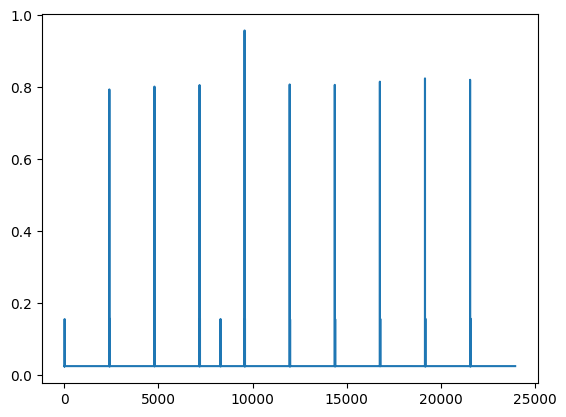

In [5]:
print(recordings_new_id)
recordings_divided = [
    recordings[:recordings_new_id[0]],
    recordings[recordings_new_id[0] + 1: recordings_new_id[1]],
    recordings[recordings_new_id[1] + 1:]
]

for recording_divided in recordings_divided:
    rs = []
    for a in range(len(recording_divided) - 1):
        x = recording_divided[a]
        y = recording_divided[a + 1]
        r = y[0] - x[0]
        rs.append(r)
    plt.plot(rs)
    plt.show()



## 1.4 Dodanie czasu względnego zamiast bezwzględnego

Dodatkowo zmiena jednostki do czasu fps w video

In [6]:
def round_to_multiple(number, multiple):
    return round(multiple * round(number / multiple), 2)


fps = 25
separation = 1 / 25

In [7]:
recordings_relative_divided = []
for recordings in recordings_divided:
    relative_times = set()  #Czasy nie powinny się powtarzać
    recordings_relative = []
    for i in range(len(recordings)):
        if i == 0:
            recordings_relative.append([0, recordings[i][1], recordings[i][2]])
            continue
        x = recordings[0]
        y = recordings[i]
        relative_time = y[0] - x[0]
        relative_time = round_to_multiple(relative_time, separation)
        # Jak czas się powtarza to jest pomijany
        if relative_time in relative_times:
            continue

        relative_times.add(relative_time)
        recordings_relative.append([relative_time, recordings[i][1], recordings[i][2]])
    recordings_relative_divided.append(recordings_relative)
print(recordings_relative_divided[0][:10])

[[0, 3864, 1], [0.04, 3889, 1], [0.08, 3939, 2], [0.12, 3989, 2], [0.16, 4014, 2], [0.2, 4064, 1], [0.24, 4089, 1], [0.28, 4139, 1], [0.32, 4189, 1], [0.36, 4214, 1]]


# 2. Nagrania video

In [8]:
video_list_files = os.listdir('videos')
print(video_list_files)

['GOPR1075.MP4', 'GOPR1076.MP4', 'GOPR1077.MP4']


## 2.1 Zbadanie średniej jasności pikseli

In [9]:
frames_light_times = []
for video_name in video_list_files:
    video_path = os.path.join('videos', video_name)
    cap = cv2.VideoCapture(video_path)
    frames_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    video_time = frames_count / fps
    frames_light_time = []

    if (cap.isOpened() == False):
        print("Error opening video stream or file")

    pbar = tqdm(total=frames_count)
    succ = fail = 0
    while (cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            fail += 1
            continue
        else:
            succ += 1
        if succ == frames_count:
            break

        # cv2.imshow('Frame',frame)
        frame_light = round(np.average(frame) / 256, 2)
        frame_time = round(succ / fps, 2)
        frames_light_time.append([frame_light, frame_time])

        pbar.update(1)
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break

    # print(succ, fail)
    cap.release()
    cv2.destroyAllWindows()
    frames_light_times.append(frames_light_time)

100%|█████████▉| 22233/22244.0 [01:30<00:00, 211.30it/s]
100%|█████████▉| 22243/22244.0 [01:30<00:00, 245.28it/s]

  0%|          | 11/17354.0 [00:01<40:04,  7.21it/s]
  0%|          | 34/17354.0 [00:01<11:01, 26.18it/s]
  0%|          | 55/17354.0 [00:01<06:15, 46.06it/s]
  0%|          | 76/17354.0 [00:01<04:14, 67.78it/s]
  1%|          | 97/17354.0 [00:01<03:11, 89.97it/s]
  1%|          | 116/17354.0 [00:02<02:39, 108.11it/s]
  1%|          | 137/17354.0 [00:02<02:13, 128.63it/s]
  1%|          | 157/17354.0 [00:02<02:00, 142.41it/s]
  1%|          | 177/17354.0 [00:02<01:51, 154.63it/s]
  1%|          | 198/17354.0 [00:02<01:42, 168.07it/s]
  1%|▏         | 218/17354.0 [00:02<01:38, 173.27it/s]
  1%|▏         | 238/17354.0 [00:02<01:36, 177.91it/s]
  1%|▏         | 258/17354.0 [00:02<01:33, 183.70it/s]
  2%|▏         | 278/17354.0 [00:02<01:31, 186.64it/s]
  2%|▏         | 298/17354.0 [00:02<01:30, 188.60it/s]
  2%|▏         | 319/17354.0 [00:03<01:27, 194.64it/s]
  2%|▏         

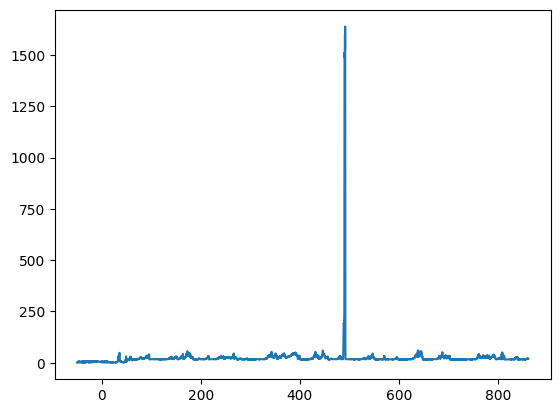

In [18]:
# print(frames_light_time[:10])
light_y = [x[0] for x in frames_light_times[0]]
light_x = [x[1] for x in frames_light_times[0]]


recordings_moved = [[x[0] - 49, x[1], x[2]] for x in recordings_relative_divided[0]]
# print(recordings_relative_divided[0][:10])
record_y = [x[2] for x in recordings_moved]
# record_y = [x[2] / 100 if x[2] < 100 else 1 for x in recordings_moved]
record_x = [x[0] for x in recordings_moved]

plt.plot(record_x, record_y)
# plt.plot(light_x, light_y)

plt.show()

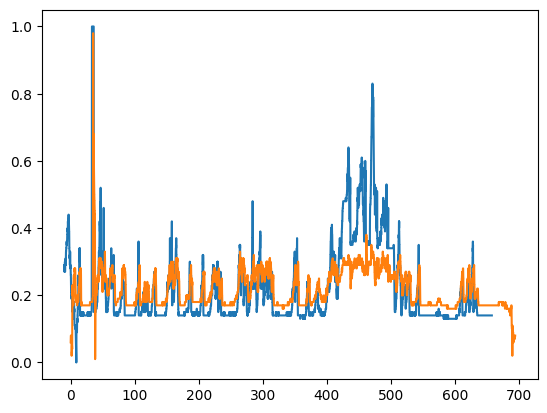

In [11]:
light_y = [x[0] for x in frames_light_times[1]]
light_x = [x[1] for x in frames_light_times[1]]


recordings_moved = [[x[0] - 10, x[1], x[2]] for x in recordings_relative_divided[1]]
record_y = [x[2] / 100 if x[2] < 100 else 1 for x in recordings_moved]
record_x = [x[0] for x in recordings_moved]

plt.plot(record_x, record_y)
plt.plot(light_x, light_y)

plt.show()

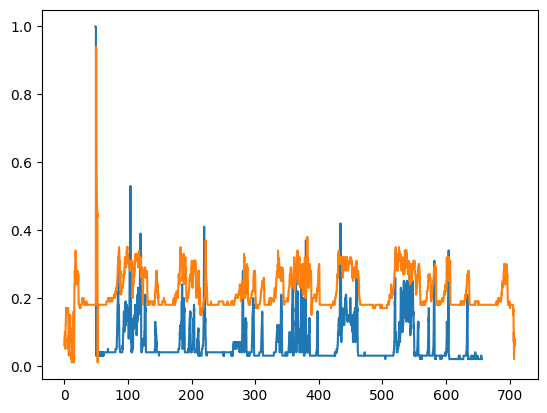

In [12]:
light_y = [x[0] for x in frames_light_times[2]]
light_x = [x[1] for x in frames_light_times[2]]


recordings_moved = [[x[0] + 49, x[1], x[2]] for x in recordings_relative_divided[2]]
ys = record_y = [x[2] for x in recordings_moved]
record_y = [x[2] / 100 if x[2] < 100 else 1 for x in recordings_moved]
record_x = [x[0] for x in recordings_moved]

plt.plot(record_x, record_y)
plt.plot(light_x, light_y)
# plt.plot(record_x, record_y)
plt.show()

## 2.2 Przesunięcie recordings o daną wartość

In [13]:
move_recording_values = [-49, -10, 50]

In [16]:
recordings_moved_all = []
outlier_value = 100
for recordings, move_value in zip(recordings_relative_divided, move_recording_values):
    recordings_moved = []
    for x in recordings:
        new_x2 = x[2] / outlier_value if x[2] < outlier_value else 1
        new_x0 = x[0] + move_value
        recordings_moved.append([new_x0, x[1], new_x2])

    recordings_moved_all.append(recordings_moved)

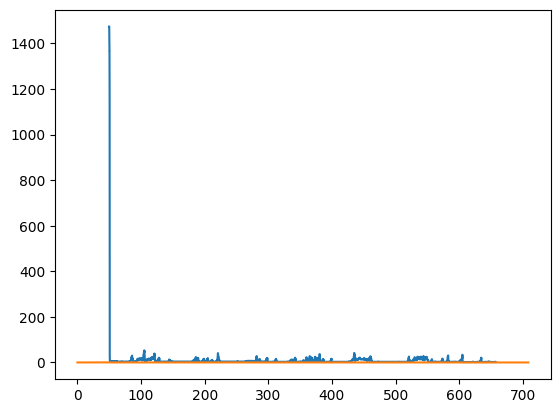

In [17]:
n = 2
light_y = [x[0] for x in frames_light_times[n]]
light_x = [x[1] for x in frames_light_times[n]]

record_y = [x[2] for x in recordings_moved_all[n]]
record_x = [x[0] for x in recordings_moved_all[n]]

plt.plot(record_x, record_y)
plt.plot(light_x, light_y)
plt.show()

## 2.3 Obcięcie nagrań

In [25]:
data = []
for i in range(len(recordings_moved_all)):
    d = []
    for r in tqdm(recordings_moved_all[i]):
        for frame_id, f in enumerate(frames_light_times[i]):
            if r[0] == f[1]:
                # d.append([frame_id, r[0], r[2], f[0]])
                d.append([frame_id, r[2],])
                continue
    data.append(d)

print(data[0][:10])


100%|██████████| 14974/14974 [00:52<00:00, 286.45it/s]

[[24, 0.08], [49, 0.1], [74, 0.04], [99, 0.06], [107, 0.06], [116, 0.06], [124, 0.04], [132, 0.1], [141, 0.12], [149, 0.16]]


In [26]:
for x in data[0][500:600]:
    print(x)
print(len(data[0]))

[1422, 0.48]
[1424, 0.42]
[1426, 0.44]
[1428, 0.44]
[1429, 0.46]
[1431, 0.52]
[1433, 0.52]
[1435, 0.5]
[1438, 0.52]
[1440, 0.54]
[1442, 0.56]
[1444, 0.58]
[1445, 0.58]
[1447, 0.54]
[1449, 0.5]
[1451, 0.5]
[1453, 0.5]
[1454, 0.5]
[1456, 0.5]
[1458, 0.5]
[1460, 0.5]
[1463, 0.54]
[1465, 0.56]
[1467, 0.52]
[1469, 0.52]
[1470, 0.52]
[1472, 0.5]
[1474, 0.52]
[1476, 0.52]
[1478, 0.54]
[1479, 0.54]
[1481, 0.52]
[1483, 0.48]
[1485, 0.48]
[1488, 0.48]
[1490, 0.46]
[1492, 0.4]
[1494, 0.4]
[1495, 0.4]
[1497, 0.38]
[1499, 0.38]
[1501, 0.38]
[1503, 0.32]
[1504, 0.32]
[1506, 0.3]
[1508, 0.32]
[1510, 0.3]
[1513, 0.28]
[1515, 0.28]
[1517, 0.28]
[1519, 0.28]
[1520, 0.28]
[1522, 0.28]
[1524, 0.28]
[1526, 0.28]
[1528, 0.26]
[1529, 0.26]
[1531, 0.26]
[1533, 0.26]
[1535, 0.24]
[1538, 0.26]
[1540, 0.26]
[1542, 0.28]
[1544, 0.26]
[1545, 0.26]
[1547, 0.24]
[1549, 0.26]
[1551, 0.26]
[1553, 0.26]
[1554, 0.24]
[1556, 0.24]
[1558, 0.24]
[1560, 0.26]
[1563, 0.26]
[1565, 0.26]
[1567, 0.26]
[1569, 0.28]
[1570, 0.28]


In [27]:
import csv

for i, records in enumerate(data):
    f = open(f"data_unclassified_stripped/data_{i}.csv", 'w', newline='', encoding='utf-8')
    writer = csv.writer(f)
    writer.writerows(records)
    f.close()